# Feature Sets Experiments

In this notebook we analyse results obtained from the feature sets experiments. The experimental design is as follows:

2. Let $m$ represent the machine learning model where $m$ $\in$ `["ADA", "LR", "DT", "RF"]`
3. Let $full$, $train$ and $test$ represent the full, training & testing subsets respectively. $train$ and $test$ are $0.75$ and $0.25$ of $full$ respectively
4. Let $train_{n}$ and $test_{n}$ be sub-subsets of the corresponding subsets where `n` $\in$ `[3, max(num_features)]`
5. Let $m\prime_{n}$ be the model trained using $train_{n}$
6. Let $\hat{y}_{n, m\prime}$ be the predictions obtained from $m\prime_{n}$ on $test_{n}$
7. Let $d$ represent the group fairness metric where $d$ $\in$ `["DI", "SPD"]`
7. Let $v_{test, n, d}$ be data fairness metrics calculated using $test_{n}$. Similarly, let $v_{train, n, d}$ be data fairness metrics calculated using $train_{n}$
1. Let $v_{n, m\prime, d}$ be the model fairness metrics calculated using $\hat{y}_{n, m\prime}$
1. We can reduce the granularity a bit for the analysis by considering the fairness metrics across the sub-subsets. Let $v_{test, d}$, $v_{train, d}$ and $v_{m\prime, d}$ represent the fairness metrics across the sub-subsets.

The objective is to analyse the following:
1. Relationship between $v_{test, d}$ and $v_{m\prime, d}$
2. Relationship between $v_{train, d}$ and $v_{m\prime, d}$
3. And finally relationship between $v_{test, d}$, $v_{train, d}$ and $v_{m\prime, d}$

Our hypothesis is that $v_{test/train, d}$ and $v_{m\prime, d}$ have some form of relationship. Another way of formulating the above statement is that the two random variables have similar distribution.

We employ two types of tests to verify our hypothesis:
1. Correlation and
2. Linear regression

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [3]:
import glob
from src.data import process

ITERATIONS=25
frames = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-feature-sets-*-{}.csv".format(ITERATIONS)))]
data = pd.concat(frames)
data = data[data["privileged"] == "None"]
process(data)
data.shape

(18750, 26)

In [4]:
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data["dataset_label"].unique()

array(['compas-sex', 'german-age', 'adult-sex', 'compas-race', 'bank-age',
       'german-sex', 'meps-race', 'adult-race'], dtype=object)

In [5]:
data.dtypes

TN                               float64
privileged                        object
FNR                              float64
true_positive_rate_difference    float64
num_negatives                    float64
statistical_parity_difference    float64
FN                               float64
iteration                          int64
model                             object
base_rate                        float64
TPR                              float64
num_positives                    float64
disparate_impact                 float64
FPR                              float64
TNR                              float64
theil_index                      float64
dataset_label                     object
accuracy                         float64
num_features                       int64
protected                         object
TP                               float64
FP                               float64
subset_label                      object
f1                               float64
PPV             

### Test for normality
In this section we validate that the random variables in our experiment are normally distributed. We employ two methods:

1. QQ plot and
2. shapiro-wilk test

#### QQ Plots
In this section we visually investigate if the distribution of the data & model fairness metrics are normally distributed.

We generate two figures, one for each fairness metric. Within each metric, we generate a 3x8 grid of plots, each row containing 3 QQ plots (one each for $v_{test, d}$, $v_{train, d}$ and $v_{m\prime, d}$).

For simplicity, we limit our analysis to the DI fairness metric & the RF classifier.

In [6]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points

datasets = data["dataset_label"].unique().tolist()
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "test") &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*ITERATIONS

    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*ITERATIONS


    for model in models:
        _ = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]
    assert _.shape[0] == len(_["num_features"].unique().tolist())*ITERATIONS

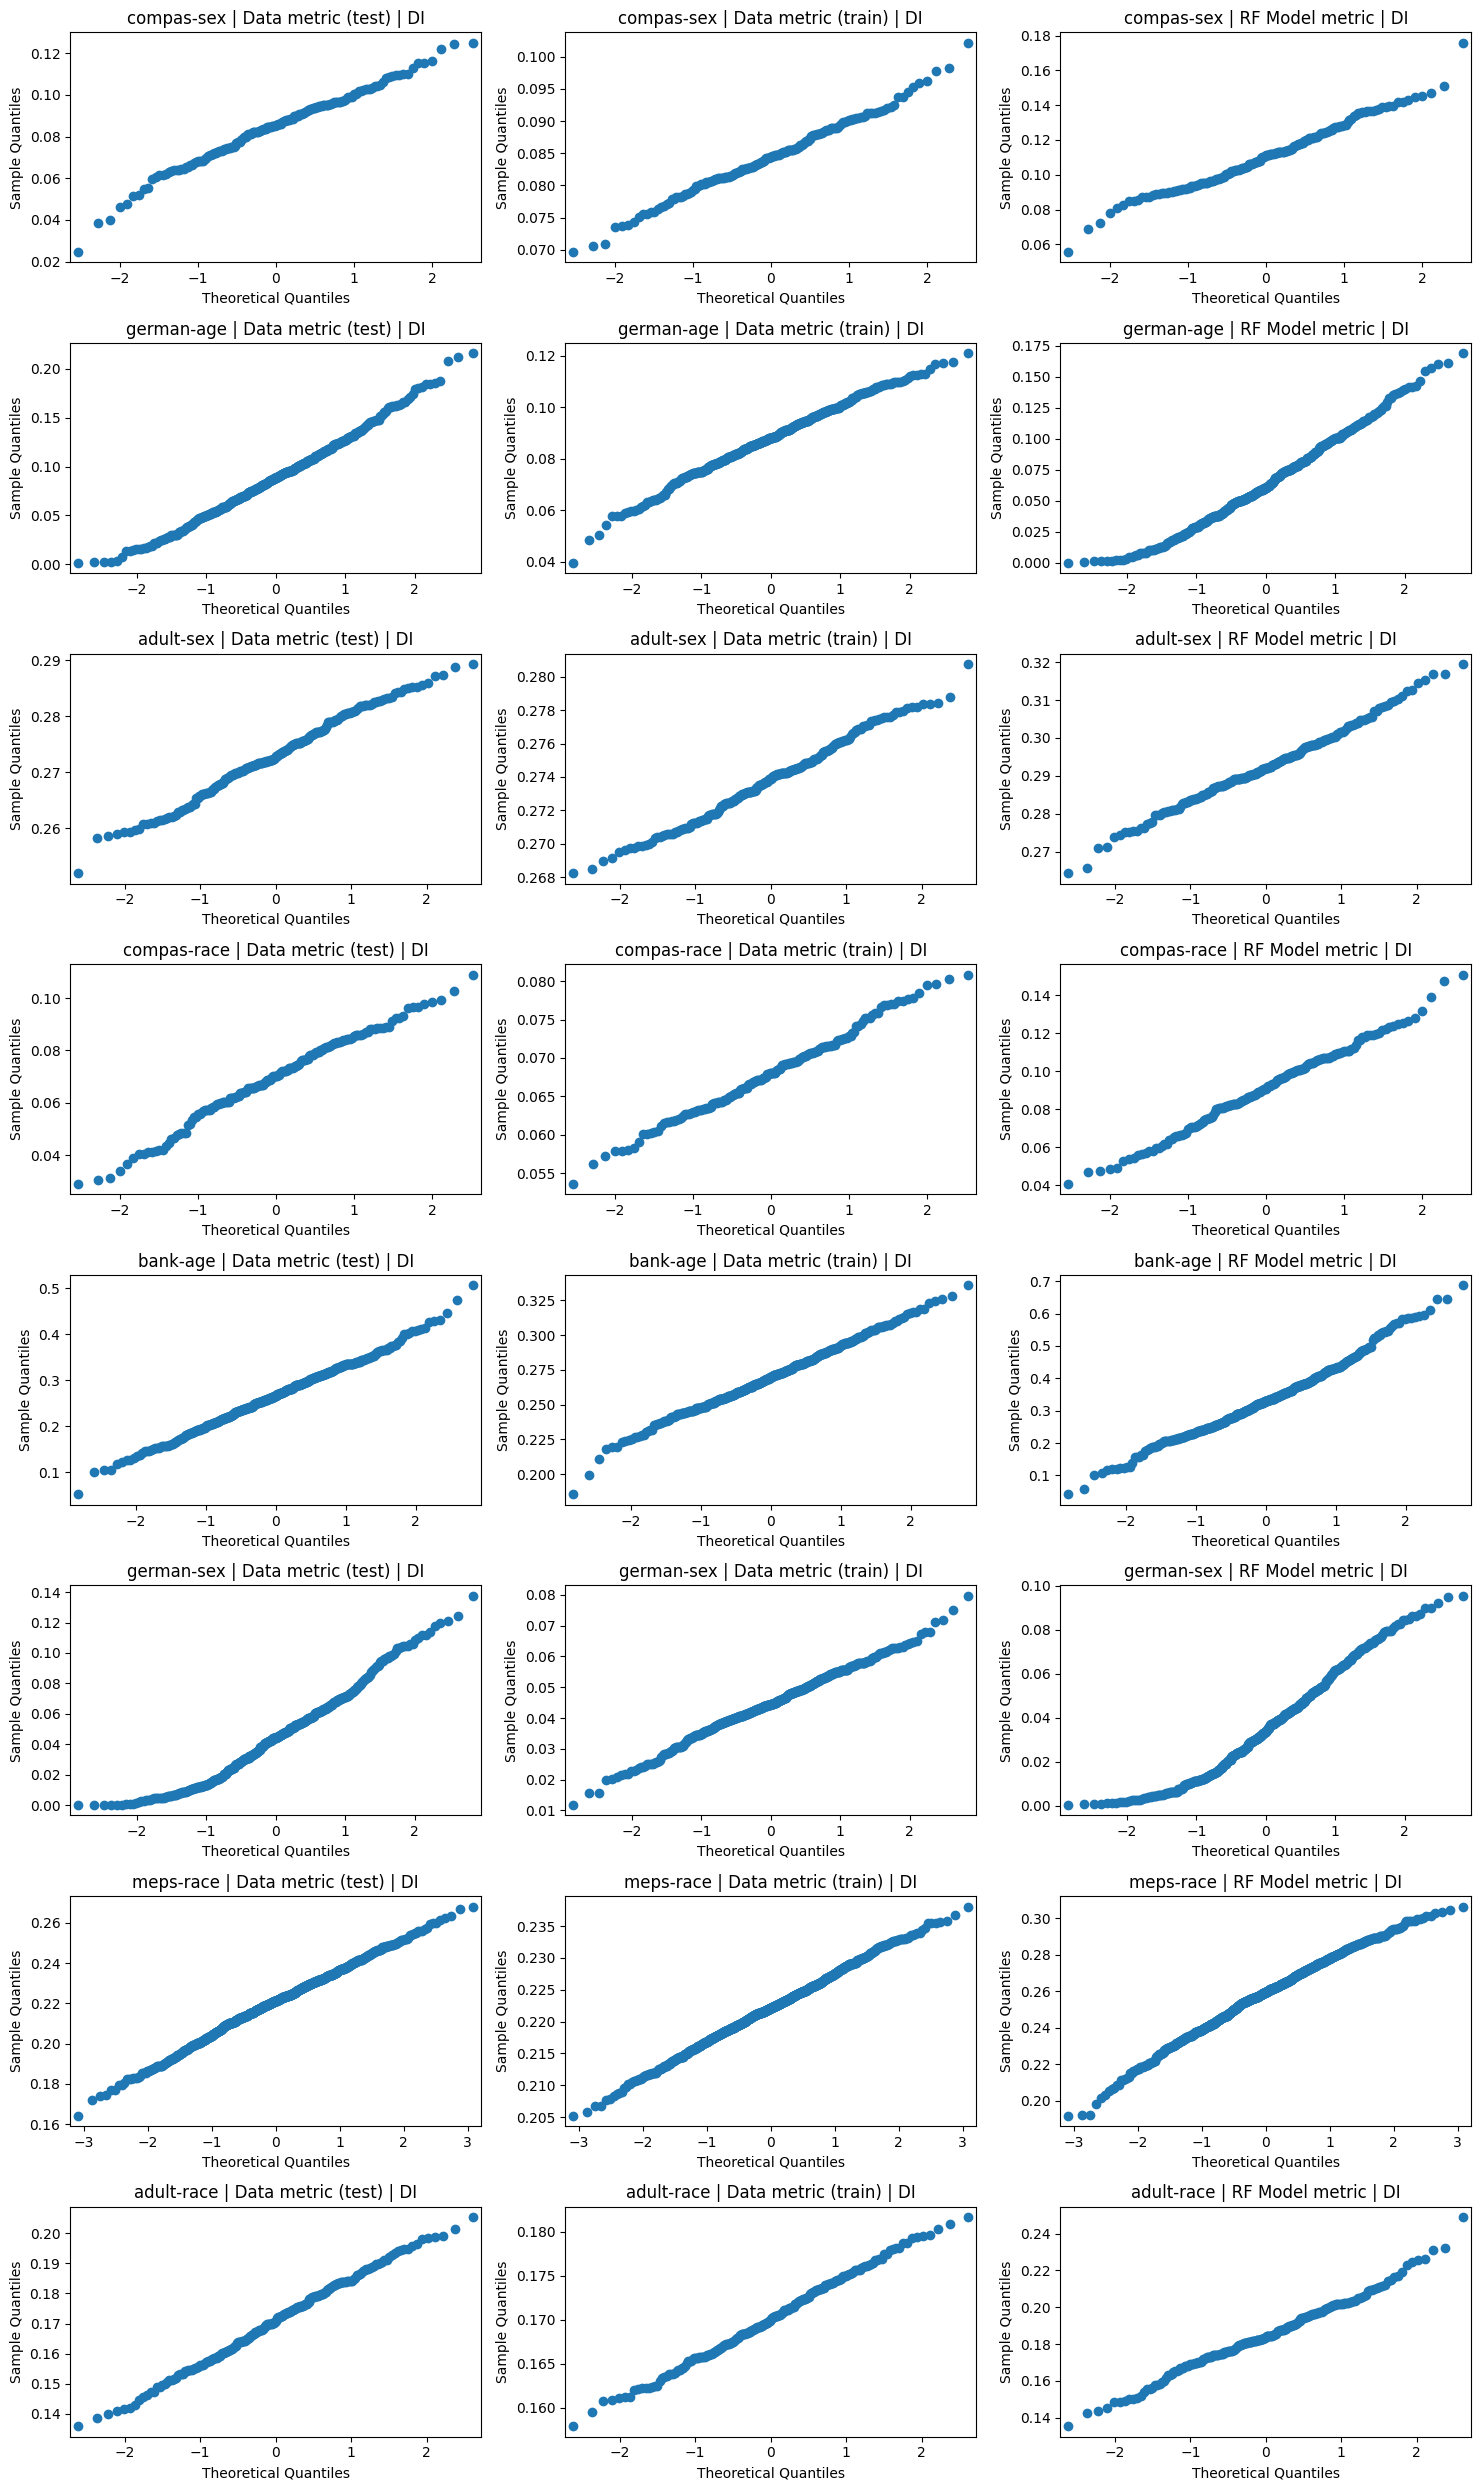

In [7]:
fig, axs = plt.subplots(
    nrows=len(datasets),
    ncols=3,
    figsize=(15,25),
)

for idx, dataset in enumerate(datasets):
    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "test") &
        (data["model"] == "None")
    ]

    ax = axs[idx, 0]
    ax.set_title("{} | Data metric (test) | DI".format(dataset))
    sm.qqplot(
        data=_["disparate_impact"],
        ax=ax,
    )

    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]

    ax = axs[idx, 1]
    ax.set_title("{} | Data metric (train) | DI".format(dataset))
    sm.qqplot(
        data=_["disparate_impact"],
        ax=ax,
    )

    _ = data[
        (data["dataset_label"] == dataset) &
        (data["model"] == "randomforestclassifier")
    ]

    ax = axs[idx, 2]
    ax.set_title("{} | RF Model metric | DI".format(dataset))
    sm.qqplot(
        data=_["disparate_impact"],
        ax=ax,
    )

fig.tight_layout()

### [Shapiro-wilk test](#sec-shapiro)
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

In [8]:
di_pvalues = {
    "dataset": [],
    "subset": [],
    "model": [],
    "shapiro": [],
}

for dataset in datasets:
    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "test") &
        (data["model"] == "None")
    ]
    di_pvalues["dataset"].append(dataset)
    di_pvalues["subset"].append("test")
    di_pvalues["model"].append("None")
    di_pvalues["shapiro"].append(shapiro(_["disparate_impact"])[1])

    _ = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]
    di_pvalues["dataset"].append(dataset)
    di_pvalues["subset"].append("train")
    di_pvalues["model"].append("None")
    di_pvalues["shapiro"].append(shapiro(_["disparate_impact"])[1])

    for model in models:
        _ = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]
        di_pvalues["dataset"].append(dataset)
        di_pvalues["subset"].append("test")
        di_pvalues["model"].append(model)
        di_pvalues["shapiro"].append(shapiro(_["disparate_impact"])[1])

di_pvalues = pd.DataFrame(data=di_pvalues)
di_pvalues


,dataset,subset,model,shapiro
0,compas-sex,test,None,1.304643e-01
1,compas-sex,train,None,8.457157e-01
2,compas-sex,test,logisticregression,8.640233e-03
3,compas-sex,test,decisiontreeclassifier,7.802777e-01
4,compas-sex,test,adaboostclassifier,4.163105e-07
5,compas-sex,test,randomforestclassifier,1.308830e-01
6,german-age,test,None,4.134035e-02
7,german-age,train,None,6.093616e-02
8,german-age,test,logisticregression,1.167781e-01
9,german-age,test,decisiontreeclassifier,3.767043e-07


In [9]:
print("di_pvalues shape: {}".format(di_pvalues.shape))

di_pvalues[di_pvalues["shapiro"] >= 0.05]

di_pvalues shape: (48, 4)


,dataset,subset,model,shapiro
0,compas-sex,test,None,0.130464
1,compas-sex,train,None,0.845716
3,compas-sex,test,decisiontreeclassifier,0.780278
5,compas-sex,test,randomforestclassifier,0.130883
7,german-age,train,None,0.060936
8,german-age,test,logisticregression,0.116778
10,german-age,test,adaboostclassifier,0.099233
12,adult-sex,test,None,0.208891
13,adult-sex,train,None,0.289726
14,adult-sex,test,logisticregression,0.875911


## Correlation
In this section we employ correlation to test if there is a relationship between the data & model metrics. From [the section above](#sec-shapiro), we note that the distribution of the populations are not normal.

We use the Spearman's correlation since it does not assume normality & is robust to outliers.

We will create individual tables for each fairness metric (DI & SPD) calculated on each subset (train & test).

$$
DI = \frac{P(y=1 | D=unprivileged)}{P(y=1 | D=privileged)}
$$
$$
SPD = P(y=1 | D=unprivileged) - P(y=1 | D=privileged)
$$

### Test subset | DI

In [10]:
# test subset | DI
from scipy.stats import spearmanr

corr = pd.DataFrame(columns=datasets)
corr_pvalues = pd.DataFrame(columns=datasets)

for d in datasets:
    _ = data[
            (data["dataset_label"] == d) &
            (data["subset_label"] == "test")
        ]
    _ = _.sort_values(by="num_features")
    _pivots = []
    for n in _["num_features"].unique().tolist():
        _pivots.append(pd.pivot(
            data=_[_["num_features"] == n],
            index="iteration",
            columns="model",
            values="disparate_impact",
        ))
        # select the first column
        # corr["{}".format(d)] = pd.concat(_pivots).corr(method="spearman").loc[:, "None"]
    pivoted = pd.concat(_pivots)
    c, p = spearmanr(pivoted)
    corr[d] = c[:, 0]
    corr_pvalues[d] = p[:, 0]

corr = corr.set_axis(pivoted.columns, axis=0, copy=False)
corr = corr.drop("None")
corr_pvalues = corr_pvalues.set_axis(pivoted.columns, axis=0, copy=False)
corr_pvalues = corr_pvalues.drop("None")
corr

,compas-sex,german-age,adult-sex,compas-race,bank-age,german-sex,meps-race,adult-race
model,,,,,,,,
adaboostclassifier,-0.108071,-0.094054,0.285968,-0.040690,0.133402,-0.003503,0.160424,0.172416
decisiontreeclassifier,0.019430,-0.103688,0.037607,-0.008251,0.136653,-0.028404,0.067852,0.144119
logisticregression,-0.211357,-0.063588,0.257967,-0.280387,0.134397,0.063084,0.195025,0.183912
randomforestclassifier,-0.092446,-0.052128,0.253427,-0.100517,0.160197,0.187677,0.201295,0.225781


Text(50.72222222222221, 0.5, '')

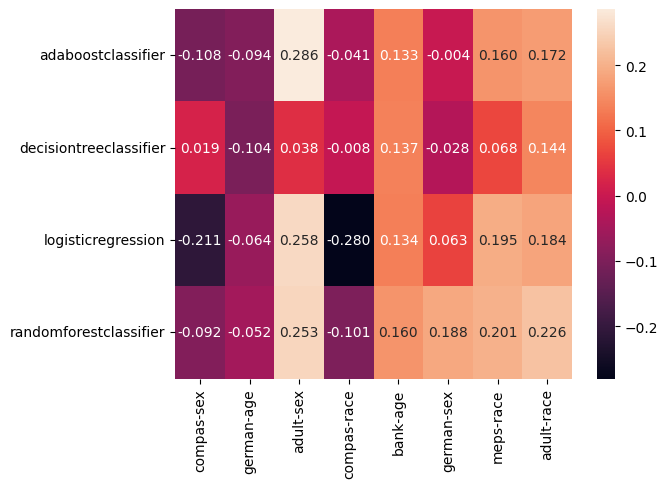

In [11]:
fig, ax = plt.subplots()

sns.heatmap(
    data=corr,
    annot=True,
    fmt=".3f",
    ax=ax,
)
ax.set_ylabel(None)

In [12]:
corr_pvalues.applymap(
    lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t])
)

,compas-sex,german-age,adult-sex,compas-race,bank-age,german-sex,meps-race,adult-race
model,,,,,,,,
adaboostclassifier,,**,***,,***,,***,***
decisiontreeclassifier,,**,,,***,,**,**
logisticregression,***,,***,***,***,,***,***
randomforestclassifier,,,***,,***,***,***,***


### Train subset | DI

In [13]:
# train subset | DI
corr = pd.DataFrame(columns=datasets)
corr_pvalues = pd.DataFrame(columns=datasets)
_frames = []

# grab the train data fairness metrics
_ = data[
    (data["model"] == "None") &
    (data["subset_label"] == "train")
]
_frames.append(_)

# grab the model metrics
_ = data[(data["model"] != "None")]
_frames.append(_)

frames = pd.concat(_frames)

for d in datasets:
    _ = frames[
            (frames["dataset_label"] == d)
        ]
    _ = _.sort_values(by="num_features")
    _pivots = []
    for n in _["num_features"].unique().tolist():
        _pivots.append(pd.pivot(
            data=_[_["num_features"] == n],
            index="iteration",
            columns="model",
            values="disparate_impact",
        ))
    pivoted = pd.concat(_pivots)
    c, p = spearmanr(pivoted)
    corr[d] = c[:, 0]
    corr_pvalues[d] = p[:, 0]

corr = corr.set_axis(pivoted.columns, axis=0, copy=False)
corr = corr.drop("None")
corr_pvalues = corr_pvalues.set_axis(pivoted.columns, axis=0, copy=False)
corr_pvalues = corr_pvalues.drop("None")
corr

,compas-sex,german-age,adult-sex,compas-race,bank-age,german-sex,meps-race,adult-race
model,,,,,,,,
adaboostclassifier,0.107545,0.090263,-0.287978,0.038603,-0.130712,0.009899,-0.159518,-0.175790
decisiontreeclassifier,-0.015827,0.098461,-0.038780,0.009550,-0.137196,0.029017,-0.067847,-0.142420
logisticregression,0.210347,0.064593,-0.258957,0.282841,-0.131925,-0.043689,-0.194902,-0.187735
randomforestclassifier,0.085733,0.055371,-0.253800,0.097691,-0.158650,-0.183622,-0.201650,-0.231221


Text(50.72222222222221, 0.5, '')

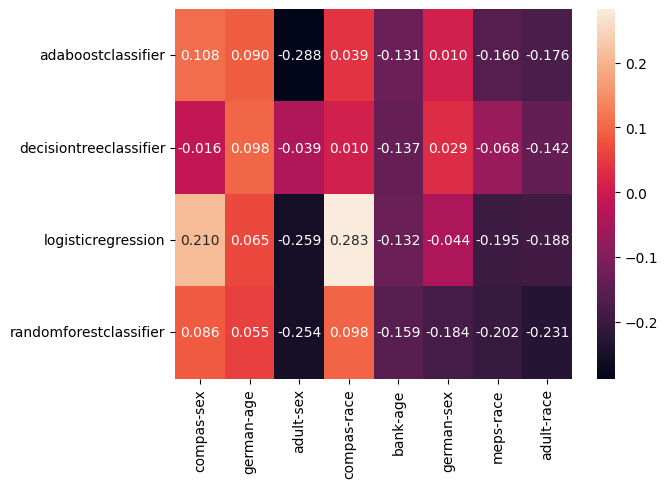

In [14]:
fig, ax = plt.subplots()

sns.heatmap(
    data=corr,
    annot=True,
    fmt=".3f",
    ax=ax,
)
ax.set_ylabel(None)

In [15]:
corr_pvalues.applymap(
    lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t])
)

,compas-sex,german-age,adult-sex,compas-race,bank-age,german-sex,meps-race,adult-race
model,,,,,,,,
adaboostclassifier,,*,***,,***,,***,***
decisiontreeclassifier,,**,,,***,,**,**
logisticregression,***,,***,***,***,,***,***
randomforestclassifier,,,***,,***,***,***,***


The results for the data metrics from the train & test subset vs. model metrics are (almost) mirror opposites. The values are not the same but the sign (positive/negative) is always the opposite.

This is counter ituitive to me. Since the model is trained using the training subet & the predictions are derived from the test subset, my ituition tells me that the data metrics from both subsets should have the same relationship with the model metrics.

The results---despite being opposites---still, somehow convey the same general message. I am just not sure how to put it in words.

Lets investigate & verify that there was no error in the data collection step. Lets look at the data metrics from both subsets over the number of features.

<AxesSubplot: xlabel='num_features', ylabel='statistical_parity_difference'>

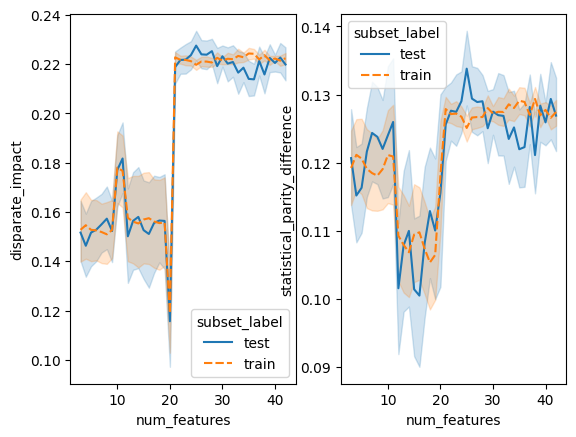

In [18]:
# _ = data[
#     (data["model"] == "None") &
#     (data["dataset_label"] == "adult-sex")
# ]

_ = data[
    (data["model"] == "None")
]

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)

ax=axs[0]
sns.lineplot(
    data=_,
    x="num_features",
    y="disparate_impact",
    hue="subset_label",
    style="subset_label",
    ax=ax,
)

ax=axs[1]
sns.lineplot(
    data=_,
    x="num_features",
    y="statistical_parity_difference",
    hue="subset_label",
    style="subset_label",
    ax=ax,
)

## Linear Regression
In this section we employ linear regression to analyse relationship between the data & model fairness metrics.

We collect the following metrics:

1. min, max & avg for $v_{test/train, d}$
2. min, max & avg for $v_{m\prime, d}$
3. coefficient(slope) of the linear regression model

In [19]:
# test subset | DI
d = {
    "dataset": [],
    "model": [],
    "x_min": [],
    "x_max": [],
    "x_mean": [],
    "y_min": [],
    "y_max": [],
    "y_mean": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
}

for dataset in datasets:
    x = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "test") &
        (data["model"] == "None")
    ]["disparate_impact"]

    for model in models:
        y = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]["disparate_impact"]
        mod = sm.OLS(
            endog=y.values.reshape(-1, 1),
            exog=x.values.reshape(-1, 1),
        )
        res = mod.fit()

        d["dataset"].append(dataset)
        d["model"].append(model)
        d["x_min"].append(x.min())
        d["x_max"].append(x.max())
        d["x_mean"].append(x.mean())
        d["y_min"].append(y.min())
        d["y_max"].append(y.max())
        d["y_mean"].append(y.mean())
        d["slope"].append(res.params[0])
        d["r2"].append(res.rsquared)
        d["f_pvalue"].append(res.f_pvalue)

reg = pd.DataFrame(data=d)
reg

,dataset,model,x_min,x_max,x_mean,y_min,y_max,y_mean,slope,r2,f_pvalue
0,compas-sex,logisticregression,0.024678,0.125027,0.084609,0.107875,0.192478,0.143335,1.623644,0.944035,7.277835e-111
1,compas-sex,decisiontreeclassifier,0.024678,0.125027,0.084609,0.035295,0.155744,0.091974,1.046542,0.915356,3.170231e-95
2,compas-sex,adaboostclassifier,0.024678,0.125027,0.084609,0.064145,0.230498,0.129253,1.462049,0.900925,2.833325e-89
3,compas-sex,randomforestclassifier,0.024678,0.125027,0.084609,0.055711,0.175846,0.110695,1.254115,0.930219,1.591813e-102
4,german-age,logisticregression,0.001674,0.215841,0.088997,0.000327,0.235804,0.102634,0.949882,0.698000,8.216205e-119
5,german-age,decisiontreeclassifier,0.001674,0.215841,0.088997,0.000213,0.193426,0.069564,0.638798,0.579212,1.975972e-86
6,german-age,adaboostclassifier,0.001674,0.215841,0.088997,0.000327,0.228539,0.099541,0.914452,0.671951,9.764529e-111
7,german-age,randomforestclassifier,0.001674,0.215841,0.088997,0.000262,0.168711,0.064279,0.598462,0.640983,6.237852e-102
8,adult-sex,logisticregression,0.251968,0.289352,0.273046,0.278737,0.334855,0.305684,1.119035,0.998858,0.000000e+00
9,adult-sex,decisiontreeclassifier,0.251968,0.289352,0.273046,0.235203,0.315849,0.271488,0.993749,0.996211,3.327147e-273


<AxesSubplot: xlabel='r2', ylabel='Count'>

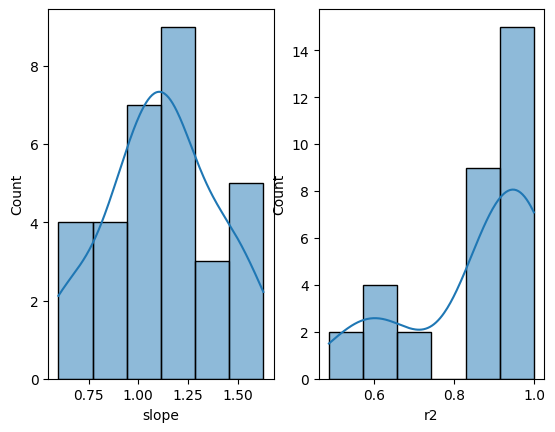

In [20]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)

ax= axs[0]
sns.histplot(
    data=reg,
    x="slope",
    ax=ax,
    kde=True,
)

ax= axs[1]
sns.histplot(
    data=reg,
    x="r2",
    ax=ax,
    kde=True,
)

In [21]:
# train subset | DI
d = {
    "dataset": [],
    "model": [],
    "x_min": [],
    "x_max": [],
    "x_mean": [],
    "y_min": [],
    "y_max": [],
    "y_mean": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
}

for dataset in datasets:
    x = data[
        (data["dataset_label"] == dataset) &
        (data["subset_label"] == "train") &
        (data["model"] == "None")
    ]["disparate_impact"]

    for model in models:
        y = data[
            (data["dataset_label"] == dataset) &
            (data["model"] == model)
        ]["disparate_impact"]
        mod = sm.OLS(
            endog=y.values.reshape(-1, 1),
            exog=x.values.reshape(-1, 1),
        )
        res = mod.fit()

        d["dataset"].append(dataset)
        d["model"].append(model)
        d["x_min"].append(x.min())
        d["x_max"].append(x.max())
        d["x_mean"].append(x.mean())
        d["y_min"].append(y.min())
        d["y_max"].append(y.max())
        d["y_mean"].append(y.mean())
        d["slope"].append(res.params[0])
        d["r2"].append(res.rsquared)
        d["f_pvalue"].append(res.f_pvalue)

reg = pd.DataFrame(data=d)
reg

,dataset,model,x_min,x_max,x_mean,y_min,y_max,y_mean,slope,r2,f_pvalue
0,compas-sex,logisticregression,0.069665,0.102160,0.084452,0.107875,0.192478,0.143335,1.692395,0.987843,1.452964e-168
1,compas-sex,decisiontreeclassifier,0.069665,0.102160,0.084452,0.035295,0.155744,0.091974,1.084445,0.946606,1.216144e-112
2,compas-sex,adaboostclassifier,0.069665,0.102160,0.084452,0.064145,0.230498,0.129253,1.526709,0.946139,2.591487e-112
3,compas-sex,randomforestclassifier,0.069665,0.102160,0.084452,0.055711,0.175846,0.110695,1.306781,0.972732,4.881637e-138
4,german-age,logisticregression,0.039618,0.120995,0.087883,0.000327,0.235804,0.102634,1.148839,0.849738,6.510814e-187
5,german-age,decisiontreeclassifier,0.039618,0.120995,0.087883,0.000213,0.193426,0.069564,0.780636,0.719875,3.775095e-126
6,german-age,adaboostclassifier,0.039618,0.120995,0.087883,0.000327,0.228539,0.099541,1.116509,0.833664,5.323362e-177
7,german-age,randomforestclassifier,0.039618,0.120995,0.087883,0.000262,0.168711,0.064279,0.718561,0.769044,5.551994e-145
8,adult-sex,logisticregression,0.268235,0.280773,0.273808,0.278737,0.334855,0.305684,1.116257,0.998865,0.000000e+00
9,adult-sex,decisiontreeclassifier,0.268235,0.280773,0.273808,0.235203,0.315849,0.271488,0.991415,0.996485,7.529038e-277


<AxesSubplot: xlabel='r2', ylabel='Count'>

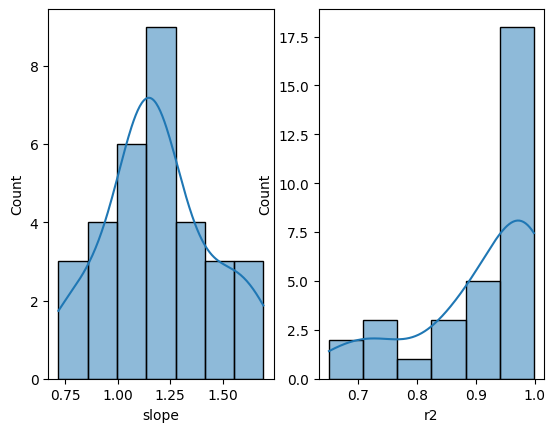

In [22]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)

ax= axs[0]
sns.histplot(
    data=reg,
    x="slope",
    ax=ax,
    kde=True,
)

ax= axs[1]
sns.histplot(
    data=reg,
    x="r2",
    ax=ax,
    kde=True,
)